## Isolation Test 3 - After ALL Ceiling Plates had been installed

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import nan
from pathlib import Path
from obspy import UTCDateTime, Stream

from andbro__get_timeaxis import __get_timeaxis
from andbro__load_FURT_stream import __load_furt_stream
from andbro__load_WROMY_stream import __load_wromy_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Configurations

In [3]:
config = {}

config['channel'] = None

config['tbeg'] = UTCDateTime("2022-09-01 00:00")
config['tend'] = UTCDateTime("2022-09-30 00:00")

# config['tbeg'] = UTCDateTime("2023-04-01 00:00")
# config['tend'] = UTCDateTime("2023-04-30 00:00")

config['path_to_figs'] = data_path+"wromy/figures/"

config['path_to_sds'] = archive_path+f'romy_archive/'

config['resample'] = 20

config['colors'] = {  'WS1':'darkgreen',
                      'WS4':'purple',
                      'WS5':'darkred',
                      'WS6':'darkblue',
                      'WS7':'darkorange',
                      'WS8':'darkcyan',
                      'WS9':'cyan',
                     }

### Methods

In [4]:
def __indicate_gaps_with_nan(df, config):

    differences = np.diff(df.totalSeconds, n=1)


    ## ______________

    sample_time_errors = [j for j in differences if j != config['resample']]

    if len(sample_time_errors) != 0:
        print(f"  -> ERROR: Found {len(sample_time_errors)} errors for the sampling time!\n")


    ## ______________

    gaps = [list(differences).index(k) for k in differences if k > 2*config['resample']] or []
    if gaps and gaps[0] in [0, 0.0]:
        gaps.pop(0)
    del differences

    for x in gaps:
        fill_row = [i+config['resample'] if n not in [3,4,5] else np.nan for n, i in enumerate(df.iloc[x,:])]
        fill_row[0] = int(df.iloc[x,0])
        fill_row[1] = int(df.iloc[x,1])
        fill_row[2] = int(df.iloc[x,2])
        df.loc[x+0.5] = fill_row


    df = df.sort_index().reset_index(drop=True).convert_dtypes()

    print(f"  -> Marked {len(gaps)} gaps with NaN values!\n")

    return df

In [5]:
def __processing(data, config):

    filter_length = 10*config['resample']

    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    print(f" -> Filter: rooling mean {filter_length}!")

    data = data[data.index % config['resample'] == 0]
    print(f" -> Resampling: keep every {config['resample']}nth sample!")

    return data

### Load WROMY Data

In [6]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+"gif_online/FURT/WETTER/")

/home/andbro/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


### Load WROMY Data

In [7]:
from andbro__load_WROMY_stream import __load_wromy_stream

In [8]:
ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
ws4 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS4", config['tbeg'], config['tend'])
ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
ws6 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS6", config['tbeg'], config['tend'])
ws7 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS7", config['tbeg'], config['tend'])
ws8 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS8", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z
Specified end: 2022-09-30T00:00:00.000000Z 
Trace end:     2022-09-29T23:59:59.000000Z


### Processing

In [9]:
def __get_sunrise_sunset(tbeg, tend):

    from obspy import UTCDateTime
    from pandas import date_range
    from suntime import Sun, SunTimeException

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    sun = Sun(48.162941, 11.275501)

    sr, ss = [], []
    for _date in date_range(tbeg.date, tend.date):
        # abd = datetime.date(2014, 10, 3)
        sr.append(sun.get_local_sunrise_time(_date))
        ss.append(sun.get_local_sunset_time(_date))

    return sr, ss

In [10]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

In [11]:
T = 3600

for _ws in [ws1, ws4, ws5, ws6, ws7, ws8, ws9]:
    _ws.select(channel="*T")[0].data = __smooth(_ws.select(channel="*T")[0].data, T)
    _ws.select(channel="*T")[0].data[:int(1.2*T)] = np.nan
    _ws.select(channel="*T")[0].data[int(-1.2*T):] = np.nan

### Plotting

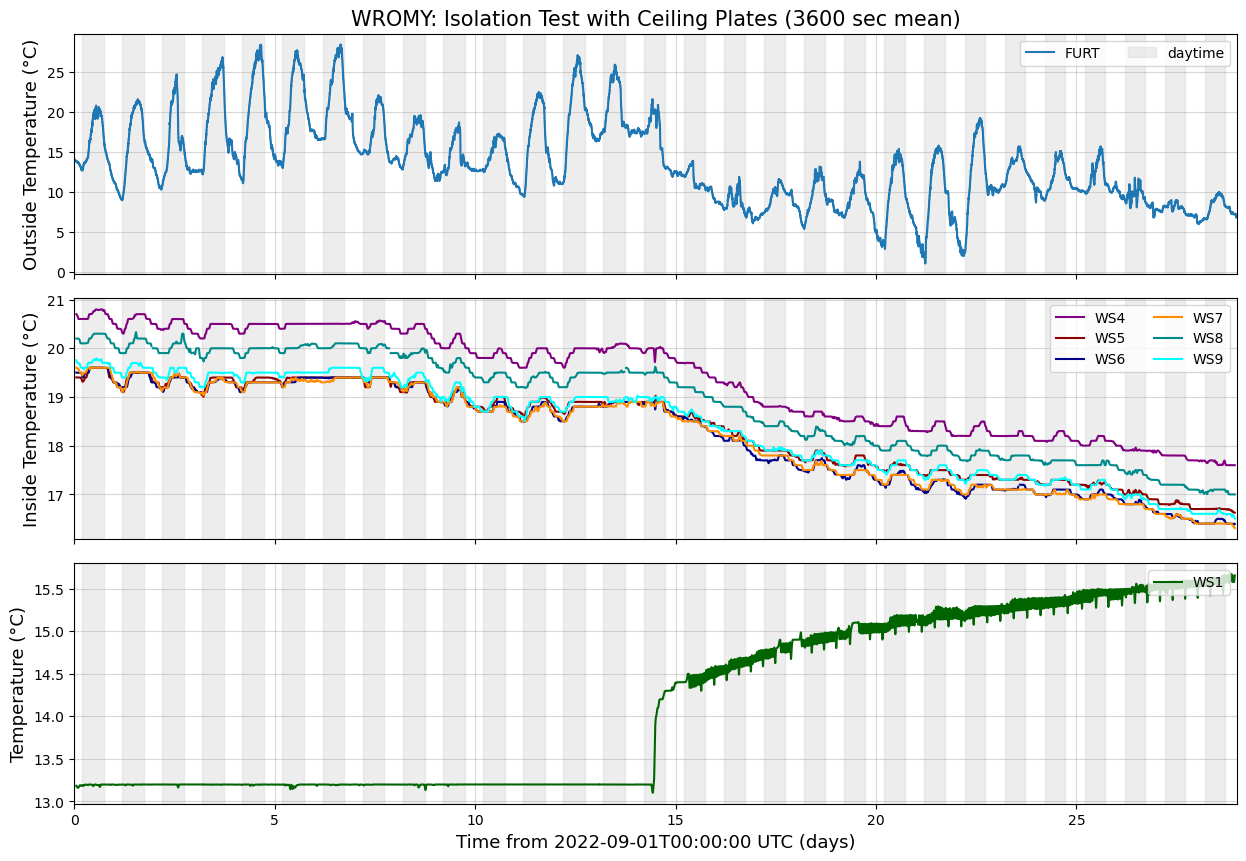

In [12]:
def __makeplot():

    N = 3
    font = 13

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ref_time = config['tbeg']

    t_scale = 86400

    ax[0].plot(furt.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               furt.select(channel="*T")[0].data, label="FURT")

    # ax[1].plot(ws1.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               # ws1.select(channel="*T")[0].data, c=config['colors']['WS1'], label="WS1")
    ax[1].plot(ws4.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws4.select(channel="*T")[0].data, c=config['colors']['WS4'], label="WS4")
    ax[1].plot(ws5.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws5.select(channel="*T")[0].data, c=config['colors']['WS5'], label="WS5")
    ax[1].plot(ws6.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws6.select(channel="*T")[0].data, c=config['colors']['WS6'], label="WS6")
    ax[1].plot(ws7.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws7.select(channel="*T")[0].data, c=config['colors']['WS7'], label="WS7")
    ax[1].plot(ws8.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws8.select(channel="*T")[0].data, c=config['colors']['WS8'], label="WS8")
    ax[1].plot(ws9.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws9.select(channel="*T")[0].data, c=config['colors']['WS9'], label="WS9")

    ax[2].plot(ws1.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws1.select(channel="*T")[0].data, c=config['colors']['WS1'], label="WS1")

    ax[0].set_title(f"WROMY: Isolation Test with Ceiling Plates ({T} sec mean)", fontsize=font+2)

    ax[0].set_ylabel("Outside Temperature (°C)", fontsize=font)
    ax[1].set_ylabel("Inside Temperature (°C)", fontsize=font)
    ax[2].set_ylabel("Temperature (°C)", fontsize=font)
    ax[2].set_xlabel(f"Time from {str(ref_time).split('.')[0]} UTC (days)", fontsize=font)

    y0min, y0max = ax[0].get_ylim()[0], ax[0].get_ylim()[1]
    y1min, y1max = ax[1].get_ylim()[0], ax[1].get_ylim()[1]
    y2min, y2max = ax[2].get_ylim()[0], ax[2].get_ylim()[1]

    sr, ss = __get_sunrise_sunset(config['tbeg'], config['tend'])

    for _n, (_sr, _ss) in enumerate(zip(sr, ss)):
        t1, t2 = (UTCDateTime(_sr)-ref_time)/t_scale, (UTCDateTime(_ss)-ref_time)/t_scale
        if _n == 0:
            ax[0].fill_betweenx([y0min, y0max], t1, t2, color="lightgrey", alpha=0.4, zorder=1, label="daytime")
        else:
            ax[0].fill_betweenx([y0min, y0max], t1, t2, color="lightgrey", alpha=0.4, zorder=1)

        ax[1].fill_betweenx([y1min, y1max], t1, t2, color="lightgrey", alpha=0.4, zorder=1)
        ax[2].fill_betweenx([y2min, y2max], t1, t2, color="lightgrey", alpha=0.4, zorder=1)

    ax[0].set_ylim(y0min, y0max)
    ax[1].set_ylim(y1min, y1max)
    ax[2].set_ylim(y2min, y2max)

    for n in range(N):
        ax[n].legend(loc=1, ncol=2)
        ax[n].grid(alpha=0.5, zorder=-1)
        ax[n].set_xlim(0, (config['tend'] - ref_time)/t_scale)

    plt.show();
    return fig

fig = __makeplot()

fig.savefig(config['path_to_figs']+f"IsolationCheck_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=200, bbox_inches='tight')


In [13]:
def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

    import multitaper as mt

    out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)

    _f, _psd = out_psd.rspec()

    f = _f.reshape(_f.size)
    psd = _psd.reshape(_psd.size)

    ## 95% confidence interval
    # _psd95 = out_psd.jackspec()
    # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

    return f, psd

In [14]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

In [15]:
def __get_fft(signal_in, dt, window=None):

    '''
    Calculating a simple 1D FastFourierSpectrum of a time series.

    RETURN:

    frequencies, spectrum, phase

    TEST:

    >>> spectrum, frequencies, phase = __fft(signal_in, dt ,window=None,normalize=None)
    '''

    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag
    ## determine length of the input time series
    n = int(len(signal_in))


    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win)

    else:
        spectrum = fft(signal_in)

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)


    ## correct amplitudes of spectrum
    magnitude = abs(spectrum) * 2.0 / n


    phase = angle(spectrum, deg=False)
    # phase = imag(spectrum)

    ## return the positive frequencies
    return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [16]:
def interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

DPSS using interpolation 2505599 1000000


(0.01, 10.0)

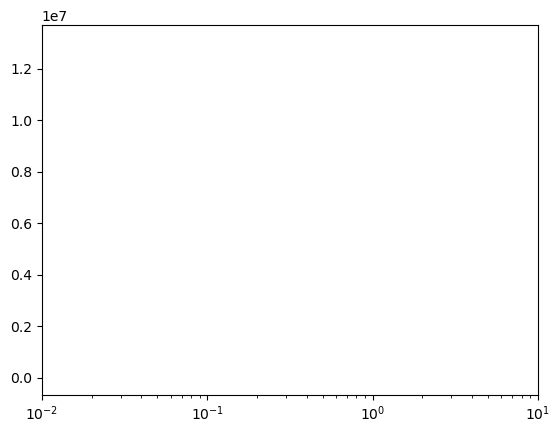

In [17]:
Koffset = 273.15

dat = furt.select(channel="*T")[0].data

dat = interpolate_nan(dat)
dat = dat+Koffset
dat -= np.mean(dat)

f_furt, psd_furt = __multitaper_psd(dat, furt[0].stats.delta, n_win=5, time_bandwidth=3.0)
# f_furt, psd_furt = __welch_psd(dat, furt[0].stats.delta, twin_sec=86400)
# f_furt, psd_furt, ph_furt = __get_fft(dat, furt[0].stats.delta, window="hann")

# plt.loglog(f_furt, psd_furt)
plt.semilogx(f_furt/86400, psd_furt)
plt.xlim(1e-2, 1e1)

In [ ]:
Koffset = 273.15

ff, psd = [], []
for _ws in [ws1, ws4, ws5, ws6, ws7, ws8, ws9]:
    _dat = interpolate_nan(_ws.select(channel="*T")[0].data)
    _dat = _dat+Koffset
    _dat -= np.mean(_dat)

    _ff, _psd = __multitaper_psd(_dat, _ws[0].stats.delta, n_win=5, time_bandwidth=3.0)
    # _ff, _psd, _ph = __get_fft(_dat, _ws[0].stats.delta, window="hann")

    ff.append(_ff)
    psd.append(_psd)

DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000
DPSS using interpolation 2505600 1000000


In [ ]:
def __makeplot_frequency():

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    ax0 = ax.twinx()

    ll = ["ws1", "ws4", "ws5", "ws6", "ws7", "ws8", "ws9"]
    for _f, _psd, lbl in zip(ff, psd, ll):
        ax.semilogx(_f*86400, _psd, alpha=0.9, label=lbl)


    ax.semilogx(f_furt*86400, psd_furt, color="k", zorder=0)

    ax.axvline(1/(24*3600)*86400, color="tab:grey", ls="--")
    # ax.axvline(1/(16*3600)*86400, color="tab:grey", ls="--")
    ax.axvline(1/(12*3600)*86400, color="tab:grey", ls="--")
    # ax.axvline(1/(6*3600)*86400, color="tab:grey", ls="--")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.set_xlim(1e-2, 1e2)
    ax.set_ylim(1e-2, 1e8)
    # ax0.set_ylim(0, 0.01)

    ax.set_yscale("log")
    ax0.set_yscale("log")

    ax.set_xlabel("Frequency (cycles/day)")
    ax.set_ylabel("PSD (K$^2$/Hz)")
    ax0.set_ylabel("PSD (K$^2$/Hz)")

    plt.show();
    return fig

fig = __makeplot_frequency()

fig.savefig(config['path_to_figs']+f"IsolationCheck_{config['tbeg'].date}_{config['tend'].date}_Spectrum.png", format="png", dpi=200, bbox_inches='tight')


In [ ]:
def __makeplot_period():

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))


    ax0 = ax.twinx()
    ax0.semilogx(1/f_ws1[1:], psd_ws1[1:], alpha=0.9)
    ax0.semilogx(1/f_ws4[1:], psd_ws4[1:], alpha=0.9)
    ax0.semilogx(1/f_ws5[1:], psd_ws5[1:], alpha=0.9)
    ax0.semilogx(1/f_ws6[1:], psd_ws6[1:], alpha=0.9)
    ax0.semilogx(1/f_ws7[1:], psd_ws7[1:], alpha=0.9)
    ax0.semilogx(1/f_ws8[1:], psd_ws8[1:], alpha=0.9)
    ax0.semilogx(1/f_ws9[1:], psd_ws9[1:], alpha=0.9)

    ax.semilogx(1/f_furt[1:], psd_furt[1:]-Koffset, color="k", zorder=0)

    ax.axvline(24*3600, color="tab:grey", ls="--")
    ax.axvline(12*3600, color="tab:grey", ls="--")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.set_xlim(1e2, 1e6)
    # ax.set_ylim(0, 1.0)
    # ax0.set_ylim(0, 0.25)

    ax.set_yscale("log")
    ax0.set_yscale("log")

    ax.set_xlabel("Period (s)")
    ax.set_ylabel("PSD (K$^2$/Hz)")
    ax0.set_ylabel("PSD (K$^2$/Hz)")

    plt.show();

# __makeplot_period()